## Project 3: Open-Ended ML Approach
Sabrina Peng, CS7391 - Spring 2020

In [1]:
import pandas as pd
import numpy as np
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim
import matplotlib.pyplot as plt
import string
import math, statistics, random

%matplotlib inline

import sys
import os
from tqdm import tqdm

swlist = set(stopwords.words('english'))

unable to import 'smart_open.gcs', disabling that module


In [2]:
# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
    'CC':None, # coordin. conjunction (and, but, or)  
    'CD':wn.NOUN, # cardinal number (one, two)             
    'DT':None, # determiner (a, the)                    
    'EX':wn.ADV, # existential ‘there’ (there)           
    'FW':None, # foreign word (mea culpa)             
    'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
    'JJ':wn.ADJ, # adjective (yellow)                  
    'JJR':wn.ADJ, # adj., comparative (bigger)          
    'JJS':wn.ADJ, # adj., superlative (wildest)           
    'LS':None, # list item marker (1, 2, One)          
    'MD':None, # modal (can, should)                    
    'NN':wn.NOUN, # noun, sing. or mass (llama)          
    'NNS':wn.NOUN, # noun, plural (llamas)                  
    'NNP':wn.NOUN, # proper noun, sing. (IBM)              
    'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
    'PDT':wn.ADJ, # predeterminer (all, both)            
    'POS':None, # possessive ending (’s )               
    'PRP':None, # personal pronoun (I, you, he)     
    'PRP$':None, # possessive pronoun (your, one’s)    
    'RB':wn.ADV, # adverb (quickly, never)            
    'RBR':wn.ADV, # adverb, comparative (faster)        
    'RBS':wn.ADV, # adverb, superlative (fastest)     
    'RP':wn.ADJ, # particle (up, off)
    'SYM':None, # symbol (+,%, &)
    'TO':None, # “to” (to)
    'UH':None, # interjection (ah, oops)
    'VB':wn.VERB, # verb base form (eat)
    'VBD':wn.VERB, # verb past tense (ate)
    'VBG':wn.VERB, # verb gerund (eating)
    'VBN':wn.VERB, # verb past participle (eaten)
    'VBP':wn.VERB, # verb non-3sg pres (eat)
    'VBZ':wn.VERB, # verb 3sg pres (eats)
    'WDT':None, # wh-determiner (which, that)
    'WP':None, # wh-pronoun (what, who)
    'WP$':None, # possessive (wh- whose)
    'WRB':None, # wh-adverb (how, where)
    '$':None, #  dollar sign ($)
    '#':None, # pound sign (#)
    '“':None, # left quote (‘ or “)
    '”':None, # right quote (’ or ”)
    '(':None, # left parenthesis ([, (, {, <)
    ')':None, # right parenthesis (], ), }, >)
    ',':None, # comma (,)
    '.':None, # sentence-final punc (. ! ?)
    ':':None # mid-sentence punc (: ; ... – -)
}

In [3]:
df = pd.read_csv("metadata.csv")
metadata = df.copy()
metadata.head()

,doc_name,tag_1,tag_2,tag_3,tag_4
0,Coronavirus_1,Coronavirus,ViralGenome,NaN,NaN
1,Coronavirus_2,Coronavirus,NaN,NaN,NaN
2,Coronavirus_3,Coronavirus,NaN,NaN,NaN
3,Coronavirus_4,Coronavirus,NaN,NaN,NaN
4,Coronavirus_5,Coronavirus,NaN,NaN,NaN


In [4]:
doc_names = list(metadata["doc_name"])
doc_names = [doc_name.strip() for doc_name in doc_names]

tags1 = list(metadata["tag_1"])
tags2 = list(metadata["tag_2"])
tags3 = list(metadata["tag_3"])

In [5]:
doc_tags = []
main_doc_tags_unsorted = []
for (doc, tag1, tag2, tag3) in tqdm(zip(doc_names, tags1, tags2, tags3)):
    main_tag = str(doc).split("_", 1)[0]
    main_doc_tags_unsorted.append(main_tag)
    
    tags = [tag1, tag2, tag3]
    tags = [tag.strip() for tag in tags if str(tag) != 'nan']
    doc_tags.append(tags)

2000it [00:00, 320236.99it/s]


In [6]:
doc_tags_dict = dict(zip(doc_names, doc_tags)) 
main_doc_tags_dict = dict(zip(doc_names, main_doc_tags_unsorted))

In [7]:
unique_doc_tags = np.unique(np.array([tag for sublist in doc_tags for tag in sublist]))

## Wrinkle Corpus Generation

In [8]:
docs = []
titles = []
abstracts = []
main_doc_tags = []

corpusDir = "_corpus/"
files = os.listdir(corpusDir)

for file in tqdm(files):
    doc = file
    docs.append(doc)
    main_doc_tags.append(main_doc_tags_dict[file])
    
    with open(corpusDir + file, "r", encoding="utf-8") as f:
        title = f.readline().strip()
        space = f.readline()
        abstract = f.readline().strip()
        titles.append(title)
        abstracts.append(abstract)

100%|██████████| 2000/2000 [00:02<00:00, 676.29it/s]


### Wrinkle: splicing together documents (10 random sentences per article)
Based on same primary tags

In [9]:
print(files[0:5])
print(main_doc_tags[0:5])

['Ethics_60', 'PublicHealthSurveillance_33', 'Ethics_94', 'Telemedicine_73', 'InfectionControl_81']
['Ethics', 'PublicHealthSurveillance', 'Ethics', 'Telemedicine', 'InfectionControl']


In [10]:
# abstract sentence tokenize
abstract_sentences = []
for abstract in tqdm(abstracts):
    sent_text = sent_tokenize(abstract)
    abstract_sentences.append(sent_text)

100%|██████████| 2000/2000 [00:02<00:00, 851.15it/s]


In [11]:
abstract_lengths = [len(abstract) for abstract in abstract_sentences]
avg_sentence_len = math.ceil(statistics.mean(abstract_lengths))

In [12]:
all_sentences_by_tag = {tag: [] for tag in unique_doc_tags} 
for doc, tag, sentences in zip(docs, main_doc_tags, abstract_sentences):
    all_sentences_by_tag[tag].extend(sentences)

In [13]:
tag_sentences = {}
for tag, sentences in all_sentences_by_tag.items():
    num_sentences = len(sentences)
    random.shuffle(sentences)
    chunks = [sentences[x: x + avg_sentence_len] for x in range(0, num_sentences, avg_sentence_len)]
    tag_sentences[tag] = chunks

In [15]:
# create new files
counter = 0
for tag, contents in tag_sentences.items():
    for sentences in contents:
        doc_name = tag + "_" + str(counter).zfill(3)
        file = "_corpus_augmented_full_splice/" + doc_name
        new_text = ' '.join(sentences)
        
        f = open(file, "w")
        f.write(new_text)
        f.close()
        
        counter += 1

### Wrinkle: splicing together documents in pairs (50/50 article split)
Based on same primary tags

In [16]:
print(docs[0:5])
print(files[0:5])
print(main_doc_tags[0:5])

['Ethics_60', 'PublicHealthSurveillance_33', 'Ethics_94', 'Telemedicine_73', 'InfectionControl_81']
['Ethics_60', 'PublicHealthSurveillance_33', 'Ethics_94', 'Telemedicine_73', 'InfectionControl_81']
['Ethics', 'PublicHealthSurveillance', 'Ethics', 'Telemedicine', 'InfectionControl']


In [17]:
tag_docs = {tag: [] for tag in unique_doc_tags} 
for file in tqdm(files):
    tag = str(file).split("_", 1)[0]
    tag_docs[tag].append(file)

100%|██████████| 2000/2000 [00:00<00:00, 287468.15it/s]


In [18]:
num_docs_combined = 2
tag_docs_chunks = {tag: [] for tag in unique_doc_tags} 
for tag, docs in tag_docs.items():
    num_docs = len(docs)
    random.shuffle(docs)
    chunks = [docs[x: x + num_docs_combined] for x in range(0, num_docs, num_docs_combined)]
    tag_docs_chunks[tag].extend(chunks)

In [19]:
def tokenize_doc_by_sent(doc):
    with open(corpusDir + doc, "r", encoding="utf-8") as f:
        title = f.readline().strip()
        space = f.readline()
        abstract = f.readline().strip()
        sent_text = sent_tokenize(abstract)
        return sent_text

In [20]:
def split_list(lst):
    half = len(lst) // 2
    return lst[:half], lst[half:]

In [21]:
def split_list_random(lst):
    random.shuffle(lst)
    half = len(lst) // 2
    return lst[:half], lst[half:]

In [22]:
new_docs = {}
new_docs_random = {}
for tag, doc_chunks in tag_docs_chunks.items():
    for chunk in doc_chunks:
        doc1 = chunk[0]
        doc2 = chunk[1]
        doc1_name = tag + "_" + chunk[0].split("_", 1)[1].zfill(3)
        doc2_name = tag + "_" + chunk[1].split("_", 1)[1].zfill(3)
        
        sent1 = tokenize_doc_by_sent(doc1)
        sent2 = tokenize_doc_by_sent(doc2)

        doc11half, doc12half = split_list(sent1)
        doc21half, doc22half = split_list(sent2)
        
        new_doc_name_1 = doc1_name + "_" + doc2_name
        new_doc_name_2 = doc2_name + "_" + doc1_name
        
        new_doc_sents_1 = doc11half + doc22half
        new_doc_sents_2 = doc21half + doc12half
        
        new_docs[new_doc_name_1] = new_doc_sents_1
        new_docs[new_doc_name_2] = new_doc_sents_2

In [23]:
# create new files
for doc_name, contents in new_docs.items():
    file = "_corpus_augmented_half_splice_pairs/" + doc_name
    new_text = ' '.join(contents)
    f = open(file, "w")
    f.write(new_text)
    f.close()

### Wrinkle: splicing together documents randomly (50/50 article split)
Based on same primary tags

In [24]:
def get_halves(first_halves_docs, first_halves, second_halves_docs, second_halves):
    first_halves_zip = list(zip(first_halves_docs, first_halves))
    random.shuffle(first_halves_zip)
    first_halves_docs_random, first_halves_random = zip(*first_halves_zip)

    second_halves_zip = list(zip(second_halves_docs, second_halves))
    random.shuffle(second_halves_zip)
    second_halves_docs_random, second_halves_random = zip(*second_halves_zip)
    
    return first_halves_docs_random, first_halves_random, second_halves_docs_random, second_halves_random

In [27]:
tag_docs_chunks = {tag: [] for tag in unique_doc_tags} 
for tag, docs in tag_docs.items():
    first_halves_docs = []
    first_halves = []
    second_halves_docs = []
    second_halves = []
    
    for doc in docs:
        doc_name = tag + "_" + doc.split("_", 1)[1].zfill(3)
        first_halves_docs.append(doc_name)
        second_halves_docs.append(doc_name)
        
        sent = tokenize_doc_by_sent(doc)
        dochalf1, dochalf2 = split_list(sent)
        first_halves.append(dochalf1)
        second_halves.append(dochalf2)
    
    first_halves_docs_random, first_halves_random, second_halves_docs_random, second_halves_random = get_halves(first_halves_docs, first_halves, second_halves_docs, second_halves)

    # create new files
    for doc1, half1, doc2, half2 in zip(first_halves_docs_random, first_halves_random, second_halves_docs_random, second_halves_random):
        file = "_corpus_augmented_half_splice/" + doc1 + "_" + doc2
        contents = half1 + half2
        new_text = ' '.join(contents)

        f = open(file, "w")
        f.write(new_text)
        f.close()

## Original Preprocessing

In [28]:
# read in files and get titles / abstracts

docs = []
titles = []
abstracts = []
main_doc_tags = []

corpusDir = "_corpus/"
files = os.listdir(corpusDir)

for file in tqdm(files):
    doc = file
    docs.append(doc)
    tag = str(file).split("_", 1)[0]
    main_doc_tags.append(tag)
    
    with open(corpusDir + file, "r", encoding="utf-8") as f:     
        title = f.readline().strip()
        space = f.readline()
        abstract = f.readline().strip()
        titles.append(title)
        abstracts.append(abstract)

100%|██████████| 2000/2000 [00:01<00:00, 1417.95it/s]


In [29]:
# remove punctuation and handle nan abstracts

all_titles = [str(title).lower().translate(str.maketrans('', '', string.punctuation)) for title in titles]
all_abstracts = [str(abstract).lower().translate(str.maketrans('', '', string.punctuation)) 
                 for abstract in abstracts]

all_abstracts = ['' if abstract == 'nan' else abstract for abstract in all_abstracts]

assert len(all_titles) == len(all_abstracts)

In [30]:
# tokenize titles

tokenized_titles = []
tokenized_title_tags = []
for title in tqdm(all_titles):
    words = word_tokenize(title)
    tuples = pos_tag(words)
    tokens = [tup[0] for tup in tuples if tup[0] not in swlist and len(tup[0]) > 2 and tup[0].isalpha()]
    tags = [tag_map[tup[1]] for tup in tuples if tup[0] not in swlist and len(tup[0]) > 2 and tup[0].isalpha()]
    assert len(tokens) == len(tags)
    
    tokenized_titles.append(tokens)
    tokenized_title_tags.append(tags)

100%|██████████| 2000/2000 [00:02<00:00, 853.99it/s] 


In [31]:
# tokenize abstracts

tokenized_abstracts = []
tokenized_abstract_tags = []
for abstract in tqdm(all_abstracts):
    words = word_tokenize(abstract)
    tuples = pos_tag(words)
    tokens = [tup[0] for tup in tuples if tup[0] not in swlist and len(tup[0]) > 2 and tup[0].isalpha()]
    tags = [tag_map[tup[1]] for tup in tuples if tup[0] not in swlist and len(tup[0]) > 2 and tup[0].isalpha()]
        
    tokenized_abstracts.append(tokens)
    tokenized_abstract_tags.append(tags)

100%|██████████| 2000/2000 [00:16<00:00, 123.21it/s]


In [32]:
# intermediate texts (title + abstract before lemmatization)

intermediate_texts = []
for (title, abstract) in tqdm(zip(tokenized_titles, tokenized_abstracts)):
    intermediate_texts.append(title + abstract)

2000it [00:00, 253646.83it/s]


In [33]:
# lemmatization

wn = WordNetLemmatizer()

In [34]:
# lemmatize titles

all_lemm_titles = []
for (tokens, tags) in tqdm(zip(tokenized_titles, tokenized_title_tags)):
    lemm_tokens = [wn.lemmatize(token, tag) for (token, tag) in zip(tokens, tags) if tag is not None]
    all_lemm_titles.append(lemm_tokens)

2000it [00:00, 24563.86it/s]


In [35]:
# lemmatize abstracts

all_lemm_abstracts = []
for (tokens, tags) in tqdm(zip(tokenized_abstracts, tokenized_abstract_tags)):
    lemm_tokens = [wn.lemmatize(token, tag) for (token, tag) in zip(tokens, tags) if tag is not None]
    all_lemm_abstracts.append(lemm_tokens)

2000it [00:01, 1141.17it/s]


In [36]:
# titles and abstracts post-processing

final_titles = all_lemm_titles
final_abstracts = all_lemm_abstracts

In [37]:
# final texts (title + abstract after lemmatization)

final_texts = []
for (title, abstract) in tqdm(zip(final_titles, final_abstracts)):
    final_texts.append(title + abstract)

2000it [00:00, 290102.64it/s]


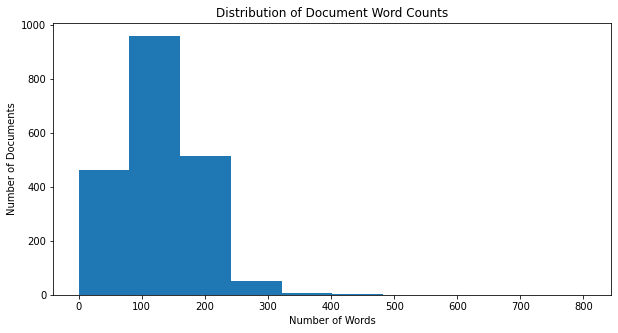

In [38]:
# find padding / truncation boundary such that most text content is preserved

text_lens = [len(text) for text in final_texts]

plt.figure(figsize=(10, 5))
plt.hist(text_lens)
plt.title("Distribution of Document Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

## Text Classification: Simple RNN (One-to-One)

In [39]:
import tensorflow as tf
from tensorflow.python import keras

In [40]:
%%time
import gensim

EMBEDDING_DIM = 300

print("Loading Word2Vec model (this may take some time)...")
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  
print("Word2Vec model loaded.")

Loading Word2Vec model (this may take some time)...
Word2Vec model loaded.
CPU times: user 2min 51s, sys: 2.11 s, total: 2min 53s
Wall time: 2min 53s


In [41]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

NUM_TOP_WORDS = None
MAX_ART_LEN = 400 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(final_texts)
sequences = tokenizer.texts_to_sequences(final_texts)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

# convert all labels to factors and then categorical (int) data

(labelFactors, factorLabels) = pd.factorize(main_doc_tags)
y_ohe = keras.utils.to_categorical(labelFactors.astype(np.uint8))

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Using TensorFlow backend.


Found 18798 unique tokens. Distilled to 18798 top words.
Shape of data tensor: (2000, 400)
Shape of label tensor: (2000, 19)
18798


In [42]:
np.unique(np.array(main_doc_tags))

array(['Coronavirus', 'Ethics', 'Immunity', 'InfectionControl',
       'InfectiousDiseaseTransmission', 'InformationDissemination',
       'Livestock', 'PointOfCareTesting', 'PostExposureProphylaxis',
       'ProtectiveFactors', 'PublicHealthSurveillance', 'RiskFactors',
       'SkilledNursingFacility', 'SocialChange', 'SocialStigma',
       'Telemedicine', 'ViralGenome', 'ViralVaccines',
       'VulnerablePopulations'], dtype='<U29')

In [43]:
from sklearn.model_selection import train_test_split
# split data into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2, random_state=42)

NUM_CLASSES = 19
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(1600, 400) (1600, 19)
[ 87.  77.  84.  82.  79.  83.  74.  83. 161.  83.  81.  79.  80.  76.
  71.  81.  82.  82.  75.]


In [44]:
EMBED_SIZE = 300 # from google news embeddings

# now fill in the matrix, using the ordering from the keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    if word in word2vec:
        embedding_vec = word2vec[word]
        embedding_matrix[i] = embedding_vec

print(embedding_matrix.shape)

(18799, 300)


In [45]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='softmax'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          5639700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 19)                1919      
Total params: 5,802,019
Trainable params: 162,319
Non-trainable params: 5,639,700
_________________________________________________________________
None


In [47]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/3
1600/1600 [==============================] - 31s 19ms/step - loss: 2.7148 - accuracy: 0.1550 - val_loss: 2.4309 - val_accuracy: 0.1900
Epoch 2/3
1600/1600 [==============================] - 30s 19ms/step - loss: 2.4192 - accuracy: 0.2688 - val_loss: 2.1423 - val_accuracy: 0.3275
Epoch 3/3
1600/1600 [==============================] - 30s 19ms/step - loss: 2.1922 - accuracy: 0.3494 - val_loss: 2.0180 - val_accuracy: 0.3675


In [48]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.9353 - accuracy: 0.4487 - val_loss: 1.6773 - val_accuracy: 0.5125
Epoch 2/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.7479 - accuracy: 0.4806 - val_loss: 1.5112 - val_accuracy: 0.5275
Epoch 3/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.5985 - accuracy: 0.5375 - val_loss: 1.4049 - val_accuracy: 0.6000


In [49]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Train on 1600 samples, validate on 400 samples
Epoch 1/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.4716 - accuracy: 0.5856 - val_loss: 1.2849 - val_accuracy: 0.6100
Epoch 2/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.3650 - accuracy: 0.6094 - val_loss: 1.2461 - val_accuracy: 0.6075
Epoch 3/3
1600/1600 [==============================] - 30s 19ms/step - loss: 1.2494 - accuracy: 0.6356 - val_loss: 1.2075 - val_accuracy: 0.6475


## Text Classification: Simple CNN (One-to-One)

In [50]:
from keras.models import Input, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Dense
from keras.layers.embeddings import Embedding

EMBED_SIZE = 300 
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)  
x = Flatten()(x)
x = Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
preds = Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 300)          5639700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 79, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 128)           8204

In [51]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.8581 - acc: 0.1356 - val_loss: 2.6022 - val_acc: 0.2225
Epoch 2/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.4884 - acc: 0.2338 - val_loss: 2.3080 - val_acc: 0.2675
Epoch 3/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.1418 - acc: 0.3519 - val_loss: 2.0145 - val_acc: 0.3625
Epoch 4/10
1600/1600 [==============================] - 5s 3ms/step - loss: 1.7227 - acc: 0.4994 - val_loss: 1.8522 - val_acc: 0.4100
Epoch 5/10
1600/1600 [==============================] - 5s 3ms/step - loss: 1.4346 - acc: 0.5681 - val_loss: 1.5335 - val_acc: 0.5350
Epoch 6/10
1600/1600 [==============================] - 4s 3ms/step - loss: 1.0811 - acc: 0.6913 - val_loss: 1.4967 - val_acc: 0.5750
Epoch 7/10
1600/1600 [==============================] - 5s 3ms/step - loss: 1.0515 - acc: 0.6969 - val_loss: 1.2168 - val_acc: 0.6525
Epoch 8/10
1600

In [52]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7860 - acc: 0.7837 - val_loss: 0.9964 - val_acc: 0.7225
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5400 - acc: 0.8581 - val_loss: 1.7471 - val_acc: 0.5550
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5319 - acc: 0.8544 - val_loss: 1.0182 - val_acc: 0.7375
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6986 - acc: 0.8131 - val_loss: 0.9856 - val_acc: 0.7175
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4511 - acc: 0.8825 - val_loss: 1.0093 - val_acc: 0.7375
Epoch 6/10
1600/1600 [==============================] - 4s 2ms/step - loss: 0.5343 - acc: 0.8600 - val_loss: 2.1965 - val_acc: 0.5150
Epoch 7/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.5455 - acc: 0.8481 - val_loss: 0.9726 - val_acc: 0.7425
Epoch 8/10
1600

In [53]:
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4153 - acc: 0.8863 - val_loss: 0.9966 - val_acc: 0.7475
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4068 - acc: 0.8869 - val_loss: 1.0794 - val_acc: 0.7375
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7677 - acc: 0.8275 - val_loss: 0.9859 - val_acc: 0.7450
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4062 - acc: 0.8863 - val_loss: 0.9953 - val_acc: 0.7400
Epoch 5/10
1600/1600 [==============================] - 4s 2ms/step - loss: 0.4073 - acc: 0.8863 - val_loss: 1.0035 - val_acc: 0.7475
Epoch 6/10
1600/1600 [==============================] - 4s 2ms/step - loss: 0.4033 - acc: 0.8875 - val_loss: 1.0296 - val_acc: 0.7500
Epoch 7/10
1600/1600 [==============================] - 4s 3ms/step - loss: 0.6806 - acc: 0.8338 - val_loss: 0.9569 - val_acc: 0.7375
Epoch 8/10
1600

## Text Classification: Larger CNN (One-to-One)

In [54]:
EMBED_SIZE = 300 
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)  
x = Conv1D(128, 5, activation='relu',kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)  
x = Flatten()(x)
x = Dense(128, activation='relu',kernel_initializer='he_uniform')(x)
preds = Dense(NUM_CLASSES, activation='softmax',kernel_initializer='glorot_uniform')(x)

model_med = Model(sequence_input, preds)
model_med.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 300)          5639700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 79, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 128)           8204

In [55]:
model_med.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.9004 - acc: 0.0931 - val_loss: 2.8759 - val_acc: 0.1375
Epoch 2/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.6526 - acc: 0.1825 - val_loss: 2.6708 - val_acc: 0.1775
Epoch 3/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.4227 - acc: 0.2587 - val_loss: 2.2700 - val_acc: 0.2950
Epoch 4/10
1600/1600 [==============================] - 5s 3ms/step - loss: 2.1307 - acc: 0.3494 - val_loss: 2.1353 - val_acc: 0.3275
Epoch 5/10
1600/1600 [==============================] - 6s 4ms/step - loss: 1.8412 - acc: 0.4412 - val_loss: 2.5807 - val_acc: 0.2700
Epoch 6/10
1600/1600 [==============================] - 4s 3ms/step - loss: 1.7098 - acc: 0.4894 - val_loss: 1.8463 - val_acc: 0.4475
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 1.4909 - acc: 0.5412 - val_loss: 1.6453 - val_acc: 0.5075
Epoch 8/10
1600

In [56]:
model_med.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.9057 - acc: 0.7494 - val_loss: 1.6064 - val_acc: 0.5275
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.9640 - acc: 0.7169 - val_loss: 1.6688 - val_acc: 0.5300
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.9418 - acc: 0.7550 - val_loss: 1.5989 - val_acc: 0.5375
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7455 - acc: 0.7925 - val_loss: 1.7990 - val_acc: 0.5350
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.8374 - acc: 0.7544 - val_loss: 2.8697 - val_acc: 0.3825
Epoch 6/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.9061 - acc: 0.7513 - val_loss: 1.2711 - val_acc: 0.6575
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6636 - acc: 0.8150 - val_loss: 1.9400 - val_acc: 0.5400
Epoch 8/10
1600

In [57]:
model_med.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6642 - acc: 0.8150 - val_loss: 1.3020 - val_acc: 0.6425
Epoch 2/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6232 - acc: 0.8238 - val_loss: 1.3988 - val_acc: 0.6400
Epoch 3/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6131 - acc: 0.8238 - val_loss: 1.4022 - val_acc: 0.6500
Epoch 4/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6022 - acc: 0.8244 - val_loss: 1.6037 - val_acc: 0.6375
Epoch 5/10
1600/1600 [==============================] - 3s 2ms/step - loss: 1.2139 - acc: 0.7519 - val_loss: 1.3642 - val_acc: 0.6575
Epoch 6/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5997 - acc: 0.8263 - val_loss: 1.4192 - val_acc: 0.6325
Epoch 7/10
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5969 - acc: 0.8269 - val_loss: 1.4301 - val_acc: 0.6575
Epoch 8/10
1600